In [1]:
%load_ext autoreload
%autoreload 2
import gc

from tqdm import tqdm

import pathlib

import torch
import torchaudio
import numpy as np
import soundfile as sf

from rt_vocaltract import datasets
from rt_vocaltract import models
from rt_vocaltract.utils import Configs

import IPython
import IPython.display as ipd

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

from wav2avatar.inversion import linear_inversion
from wav2avatar.utils import Utils

/home/prabhune/miniconda3/envs/w2a/lib/python3.10/site-packages/s3prl/upstream/byol_s/byol_a/common.py:20: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")
ESPnet is not installed, cannot use espnet_hubert upstream
/home/prabhune/miniconda3/envs/w2a/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 0

In [3]:
libri_root = pathlib.Path("/data/common/LibriTTS_R/")

wav_root = libri_root / "wavs"
feat_root = libri_root / "features"

In [4]:
root = pathlib.Path("/data/prabhune/rt_vocaltract/ckpts/")
config = Configs.load_config(root / "def" / "ssinv_def.yaml")
ckpt = root / "def" / "ssinv_l1_0.38.pth"

In [5]:
model = Configs.load_model(config, ckpt)

In [172]:
train_data, val_data, test_data = Configs.load_dataset(config)

--- loading LibriTTS_R dataset ---
-- wav root: /data/common/LibriTTS_R/wavs ---
-- feature root: /data/common/LibriTTS_R/features ---
--- loaded LibriTTS_R dataset ---
373339


In [226]:
data_path = "/data/common/LibriTTS_R"
lttsr = datasets.LibriTTSRDataset(data_path)

--- loading LibriTTS_R dataset ---
-- wav root: /data/common/LibriTTS_R/wavs ---
-- feature root: /data/common/LibriTTS_R/features ---
--- loaded LibriTTS_R dataset ---


In [237]:
wav, feat = lttsr[0]
wav = wav[:, :]
feat = feat[1650:]

In [238]:
ipd.display(ipd.Audio(wav, rate=24000))

VAL DATA 1

In [241]:
wav, feat = val_data[0]
wav = wav[:, 840000:]
feat = feat[1750:]

In [242]:
ipd.display(ipd.Audio(wav, rate=24000))

In [243]:
feat_hat = model(wav.unsqueeze(0))
feat_hat = feat_hat.transpose(2, 1)
feat_hat = feat_hat.squeeze(0).detach().numpy()
feat = feat.detach().numpy()

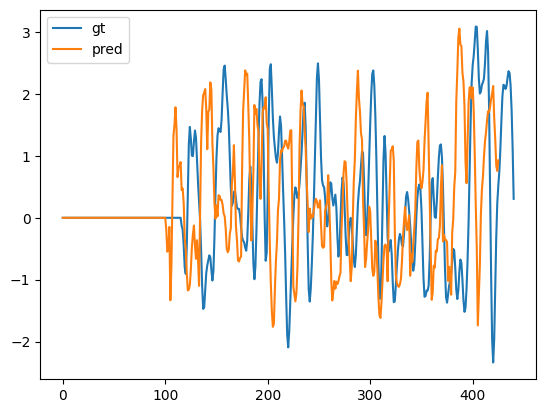

In [244]:
feat_num = 0
plt.plot(feat[:, feat_num], label="gt")
plt.plot(feat_hat[:, feat_num], label="pred")
plt.legend()

In [245]:
one_sec = model(wav[:, :48000].unsqueeze(0))
one_sec = one_sec.transpose(2, 1)
one_sec = one_sec.squeeze(0).detach().numpy()

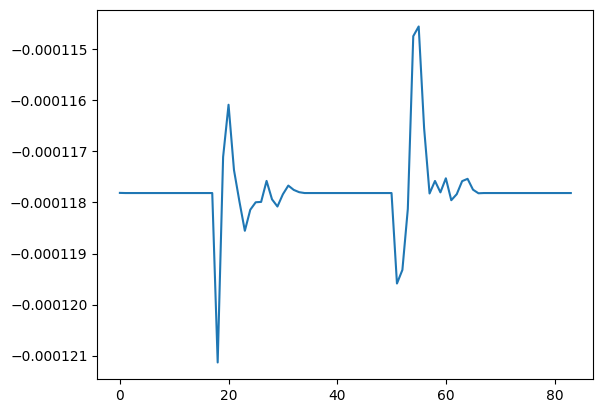

In [246]:
plt.plot(one_sec[:, feat_num])

In [7]:
def pred_wav(wav):
    feat_hat = model(wav.unsqueeze(0))
    feat_hat = feat_hat.transpose(2, 1)
    feat_hat = feat_hat.squeeze(0).detach().numpy()
    feat_hat = linear_inversion.EMADataset.butter_bandpass_filter(feat_hat, 10, 50)
    return feat_hat

In [8]:
feats = []
wav = torch.concatenate([torch.zeros((1, 48000)), wav], axis=1)
for i in range(0, wav.shape[1], 2400):
    if i + 48000 > wav.shape[1]:
        break
    feat_hat = pred_wav(wav[:, i:i+48000])
    feats.append(feat_hat[-5:])

In [324]:
feats = np.concatenate(feats, axis=0)

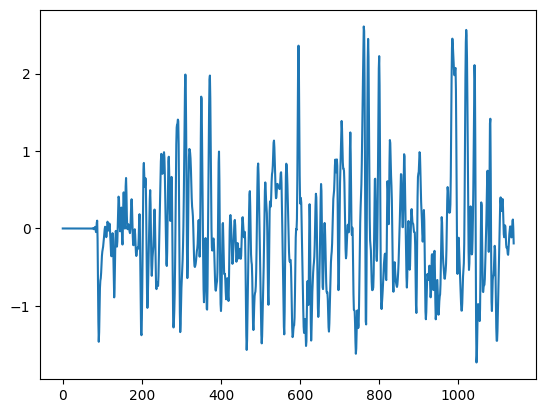

In [11]:
feat_num = 0
plt.plot(feat_hat[1:, feat_num])
#plt.plot(feat[95:, feat_num])

In [259]:
corrs = []
for feat_num in range(14):
    corr = pearsonr(feats[1:, feat_num], feat[95:-2, feat_num]).statistic
    corrs.append(corr)
    print(corr)

corrs = np.array(corrs)
print("mean:", corrs.mean())

0.8904508034772107
0.8848727378595707
0.850305832192747
0.9285192688112155
0.8466211082285552
0.9306357269528547
0.9079670287950813
0.9377659482594367
0.861750159474515
0.899065795994281
0.9143315753068297
0.9291655048949881
0.9018286523307298
0.8180610925123428
mean: 0.892952945363597


In [260]:
feats[1:, feat_num].shape
feat[95:-2, feat_num].shape

(344,)

In [208]:
corrs = []
for i, (wav, feat) in tqdm(enumerate(val_data)):
    feat_hat = model(wav.unsqueeze(0))
    feat_hat = feat_hat.transpose(2, 1)
    feat_hat = datasets.LibriTTSRDataset.pad_feat(feat_hat)
    feat_hat = feat_hat.squeeze(0).detach().numpy()
    feat = feat.detach().numpy()
    # feat_hat = linear_inversion.EMADataset.butter_bandpass_filter(feat_hat, 10, 50)
    # feat = linear_inversion.EMADataset.butter_bandpass_filter(feat, 10, 50)
    corr = np.array([pearsonr(feat[:, i], feat_hat[:, i])[0] for i in range(feat.shape[1])]).mean()
    corrs.append(corr)

    if i == 10:
        break

corrs = np.array(corrs)
print(corrs.mean(), corrs.std())

0it [00:00, ?it/s]

10it [00:15,  1.57s/it]

0.8551629996940266 0.02894975559306448


In [13]:
feat_hat_hprc = Utils.mngu0_to_hprc(feat_hat)

In [262]:
np.save("stream_val0_gt.npy", feat)

In [254]:
np.save("stream_val0.npy", feats)
np.save("stream_val0_hprc.npy", feats_hprc)

In [189]:
sf.write("stream_val0.wav", wav[:, 45600:].squeeze(0), 24000)

In [14]:
np.save("tejas_source.npy", feat_hat_hprc)

In [6]:
wav, sr = torchaudio.load("tejas_source.wav")
wav = torchaudio.functional.resample(wav, sr, 24000)
wav = wav[:1, :]

In [328]:
np.save("aai_sing_ss_hprc.npy", feats_hprc)

In [9]:
feat_hat = pred_wav(wav)